# Caudal Horn QTL Analysis of BC and F2s

##### *Date: Aug 2025*
##### *yk2840@columbia.edu*


This notebook contains the QTL anaylses for the F2s and BCs related to SuppFig 3.


## Required Libraries

In [1]:
library(dplyr)
library(stringr)
library(ggplot2)
library(reshape2)
library(qtl)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Load data

See Figure 2 code for how MSG outputs were imported into R.

In [4]:
setwd("/burg/palab/users/yk2840/workspace_Ana/Bombyx_data/MSG_analysis/data_for_github/Fig2/")

# Load Cross Data
load("BC_rQTL.RData")
load("BC_rQTL_perm.RData")

# Load Ancestry Calcs
ancestry<-read.csv("BC_ancestry_summary_per_chrom.csv")
# Load chromosome info
chr_regions<-read.delim("../../../../B_mori_50T_assembly/Bomo_genome_assembly_chr_only.fa.fai", header=FALSE)


###  Calculate Ancestry excluding BC QTL-bearing Chromosomes

In [5]:
ancestry<-ancestry[-which(ancestry$Chromosome %in% c("Chr4", "Chr5", "Chr7", "Chr9", "Chr10", "Chr21", "Chr25", "Chr26")),]
ancestry_summary <- ancestry %>%
  group_by(Individual) %>%
  summarise(
    Total_AA = sum(AA_Length, na.rm = TRUE),
    Total_AB = sum(AB_Length, na.rm = TRUE),
    Total_BB = sum(BB_Length, na.rm = TRUE)
  )
ancestry_summary$Total<-ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB * 2 + ancestry_summary$Total_BB * 2 
ancestry_summary$Prop_A<-(ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB )/ancestry_summary$Total
ancestry_summary$Prop_B<-(ancestry_summary$Total_BB*2 + ancestry_summary$Total_AB )/ancestry_summary$Total

cross$pheno$B_ancestry<-ancestry_summary$Prop_B[match(cross$pheno$id, ancestry_summary$Individual)]

### BC1 QTL Run

In [6]:
# Get Permutation Threshold
perm_thres<-summary(cross_perm, alpha=c(0.05))[1]
paste0("perm threshold =", perm_thres)

[1] "perm threshold =3.02521961503008"

In [7]:
# Convert sex into binary
cross$pheno$sex<-ifelse(cross$pheno$sex=="M", 0, ifelse(cross$pheno$sex=="F", 1, NA))

# run rqtl with covariates
ac <- pull.pheno(cross, c("weight","sex", "B_ancestry"))
out.hk <- scanone(cross, pheno.col="length", addcovar=ac, method="hk")

# extract scanone LOD intervals and peaks
lod_for_fit<-as.data.frame(summary(out.hk, threshold=perm_thres, format="tabByCol"))
out.hk.peaks<-summary(out.hk, threshold=perm_thres,  format="tabByCol")$lod
out.hk.df<-as.data.frame(out.hk)
out.hk.df$pos<-as.numeric(stringr::str_split_fixed(rownames(out.hk.df), ":", 2)[,2])
out.hk.df$chr<-as.numeric(gsub("Bomo_Chr", "", stringr::str_split_fixed(rownames(out.hk.df), ":", 2)[,1]))

lod_for_fit_top<-lod_for_fit[order(lod_for_fit$lod.lod, decreasing=TRUE),]
lod_for_fit_top$chr<-as.numeric(as.character(lod_for_fit_top$lod.chr))
lod_for_fit_top$pos<-as.numeric(stringr::str_split_fixed(rownames(lod_for_fit_top), ":", 2)[,2])
lod_for_fit_top$lod<-lod_for_fit_top$lod.lod
head(lod_for_fit_top)

,lod.chr,lod.pos,lod.ci.low,lod.ci.high,lod.lod,chr,pos,lod
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bomo_Chr4:4272201,4,12.68844,12.106047,13.86541,37.484670,4,4272201,37.484670
Bomo_Chr21:7151921,21,21.24121,19.384091,33.37049,8.145909,21,7151921,8.145909
Bomo_Chr5:12478648,5,37.06158,26.684535,44.10020,7.344390,5,12478648,7.344390
Bomo_Chr10:16216470,10,48.16292,6.715687,52.18798,4.691608,10,16216470,4.691608
Bomo_Chr26:6564000,26,19.49508,7.373901,24.06822,3.929522,26,6564000,3.929522
Bomo_Chr7:4489719,7,13.33447,4.304786,27.50629,3.449305,7,4489719,3.449305


In [8]:
# Run QTL Model
qtl <- makeqtl(cross, chr=lod_for_fit$lod.chr, pos=lod_for_fit$lod.pos, what="prob")

out.fq <- fitqtl(cross, qtl=qtl, method="hk",  pheno.col="length", formula=y~Q1*Q6+Q2+Q3+Q4+Q5+Q7+Q8+sex+weight+B_ancestry,
                 covar=ac,get.ests=TRUE)
summary(out.fq)


		fitqtl summary

Method: Haley-Knott regression 
Model:  normal phenotype
Number of observations : 694 

Full model result
----------------------------------  
Model formula: y ~ Q1 + Q6 + Q2 + Q3 + Q4 + Q5 + Q7 + Q8 + sex + weight + 
                    B_ancestry + Q1:Q6 

       df       SS         MS      LOD     %var Pvalue(Chi2) Pvalue(F)
Model  12 34.60445 2.88370386 85.25614 43.20566            0         0
Error 681 45.48795 0.06679581                                         
Total 693 80.09240                                                    


Drop one QTL at a time ANOVA table: 
----------------------------------  
               df Type III SS      LOD      %var  F value Pvalue(Chi2)
4@12.7          2   14.174735 40.87883 17.697979 106.1050        0.000
21@21.2         2    4.314355 13.65552  5.386723  32.2951        0.000
5@37.1          1    2.166708  7.01252  2.705260  32.4378        0.000
7@13.3          1    1.048987  3.43580  1.309721  15.7044        0.000
9@9.5  

In [9]:
# reformat chromosome info for plotting
chr_regions<-chr_regions[,c(1:2)]
colnames(chr_regions)<-c("chr", "pos")
chr_regions$chr<-gsub("Bomo_Chr", "", chr_regions$chr)


facet_bg <- chr_regions %>%
  distinct(chr) %>%
  mutate(color = rep(c("grey80", "white"), length.out = n()))

chr_regions <- chr_regions %>%
  left_join(facet_bg, by = "chr")

chr_regions<-as.data.frame(chr_regions)
chr_regions$chr<-as.numeric(chr_regions$chr)

In [10]:
# Extract Genotype x Phenotype data for QTL Peaks from Cross

geno_data <- as.data.frame(pull.geno(cross)[,rownames(lod_for_fit)])
geno_data[geno_data=="1"]<-"mori:mori"
geno_data[geno_data=="2"]<-"mori:mand"
geno_data[geno_data=="3"]<-"mand:mand"
geno_data$id<-cross$pheno$id
geno_data$length<-cross$pheno$length

geno_data_melt<-melt(geno_data, id.vars=c("id", "length"))
geno_data_melt$chr<-gsub("Bomo_Chr", "", stringr::str_split_fixed(geno_data_melt$variable, ":", 2)[,1])
geno_data_melt<-geno_data_melt[which(geno_data_melt$value!="NA"),]

# Extract Genotype x Phenotype data combining Top 3 QTL Peaks
geno_data$Chr4_5_21<-paste0(geno_data$`Bomo_Chr4:4272201`, "-",
                            geno_data$`Bomo_Chr5:12478648`, "-",
                            geno_data$`Bomo_Chr21:7151921`)
geno_data.all3<-geno_data[which(geno_data$Chr4_5_21=="mori:mori-mori:mori-mori:mori" | 
                                geno_data$Chr4_5_21=="mori:mand-mori:mand-mori:mand"),]
geno_data.all3.melt<-melt(geno_data.all3[,c("Chr4_5_21", "id", "length")], id.vars=c("id", "length"))
geno_data.all3.melt$value[which(geno_data.all3.melt$value=="mori:mand-mori:mand-mori:mand")]<-"mori:mand"
geno_data.all3.melt$value[which(geno_data.all3.melt$value=="mori:mori-mori:mori-mori:mori")]<-"mori:mori"
geno_data.all3.melt$chr<-"all three QTLs"

geno_data_melt$chr<-paste0("Chr ", geno_data_melt$chr)
geno_data_melt<-rbind(geno_data_melt, geno_data.all3.melt)
geno_data_melt$value<-factor(geno_data_melt$value, levels=c("mori:mori", "mori:mand", "mand:mand"))

# Extract Genotype x Phenotype data for Non Chr 4, 5, and 21 Peaks

geno_data_melt_remaining<-geno_data_melt[-which(geno_data_melt$chr %in% c("Chr 4", "Chr 21", "Chr 5", "all three QTLs")),]
geno_data_melt_remaining$chr<-factor(geno_data_melt_remaining$chr, levels=c("Chr 7", "Chr 9", "Chr 10", "Chr 25", "Chr 26"))
colnames(geno_data_melt_remaining)<-c("id", "length", "marker", "genotype", "chr")

# Extract Genotype x Phenotype data for Chr 4, 5, and 21 Peaks

geno_data_melt<-geno_data_melt[which(geno_data_melt$chr %in% c("Chr 4", "Chr 21", "Chr 5", "all three QTLs")),]
geno_data_melt$chr<-factor(geno_data_melt$chr, levels=c("Chr 4", "Chr 21", "Chr 5", "all three QTLs"))
colnames(geno_data_melt)<-c("id", "length", "marker", "genotype", "chr")

In [11]:
# Get Corresponding Phenotype Data from Cross
pheno_corrected<-as.data.frame(cross$pheno)
pheno_corrected$sex<-as.factor(pheno_corrected$sex)

# Correct Caudal Horn Length based on Sex and Weight
model <- lm(length ~ weight + sex, data = pheno_corrected)
pheno_corrected$sex<-as.numeric(as.character(pheno_corrected$sex))

beta_weight<-model$coefficients[2]
beta_sex<-model$coefficients[3]
pheno_corrected$corr_len <- pheno_corrected$length - ((beta_weight*pheno_corrected$weight)-mean((beta_weight*pheno_corrected$weight)))-
((beta_sex*pheno_corrected$sex)-mean((beta_sex*pheno_corrected$sex)))


geno_data_melt$corr_length<-pheno_corrected$corr_len[match(geno_data_melt$id, pheno_corrected$id)]
head(geno_data_melt)

geno_data_melt_remaining$corr_length<-pheno_corrected$corr_len[match(geno_data_melt_remaining$id, pheno_corrected$id)]

,id,length,marker,genotype,chr,corr_length
,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,indiv2002,1.956674,Bomo_Chr4:4272201,mori:mand,Chr 4,2.115382
2,indiv2004,1.736989,Bomo_Chr4:4272201,mori:mori,Chr 4,1.867020
3,indiv2006,1.501522,Bomo_Chr4:4272201,mori:mori,Chr 4,1.549618
4,indiv2007,2.412518,Bomo_Chr4:4272201,mori:mand,Chr 4,2.283101
5,indiv2009,2.041476,Bomo_Chr4:4272201,mori:mand,Chr 4,1.862897
6,indiv2012,1.702795,Bomo_Chr4:4272201,mori:mand,Chr 4,1.671700


In [12]:
length_avg<-aggregate(corr_length~marker+genotype+chr, data=geno_data_melt, median)
length_avg<-dcast(length_avg, marker + chr ~ genotype, value.var = "corr_length")
length_avg$Pdiff<-(length_avg$`mori:mand`-length_avg$`mori:mori`)/(3.51 - 0.94)
length_avg


# Get QTL Model Estimates
chr_pve<-as.data.frame(summary(out.fq)$ests)
chr_pve<-chr_pve[order(chr_pve$est, decreasing=TRUE),]
chr_pve$chr<-paste0("Chr ", str_split_fixed(rownames(chr_pve), "@", 2)[,1])
chr_pve<-chr_pve[which(chr_pve$chr %in% c("Chr 4", "Chr 21", "Chr 5")),]
chr_pve<-plyr::rbind.fill(chr_pve, data.frame(est=sum(chr_pve$est), chr="all three QTLs"))
               
chr_pve$est_norm_mori<-chr_pve$est/length_avg$`mori:mori`[match(chr_pve$chr, length_avg$chr)]
chr_pve$chr<-factor(chr_pve$chr, levels=c("Chr 4", "Chr 21", "Chr 5", "all three QTLs"))

marker,chr,mori:mori,mori:mand,Pdiff
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Bomo_Chr4:4272201,Chr 4,1.610970,1.900307,0.11258255
Bomo_Chr5:12478648,Chr 5,1.677584,1.805064,0.04960299
Bomo_Chr21:7151921,Chr 21,1.689655,1.837932,0.05769523
Chr4_5_21,all three QTLs,1.408154,2.102266,0.27008258


In [15]:
# Calculate Effect Size Normalized by Parental Difference
length_avg_remaining<-aggregate(corr_length~marker+genotype+chr, data=geno_data_melt_remaining, median)
length_avg_remaining<-dcast(length_avg_remaining, marker + chr ~ genotype, value.var = "corr_length")
length_avg_remaining$Pdiff<-(length_avg_remaining$`mori:mand`-length_avg_remaining$`mori:mori`)/(3.51 - 0.94) # Avg Mori and Mand Difference
length_avg_remaining

marker,chr,mori:mori,mori:mand,Pdiff
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Bomo_Chr7:4489719,Chr 7,1.690284,1.808423,0.04596860
Bomo_Chr9:3199754,Chr 9,1.703463,1.802341,0.03847426
Bomo_Chr10:16216470,Chr 10,1.689655,1.811255,0.04731516
Bomo_Chr25:2617542,Chr 25,1.715678,1.784624,0.02682735
Bomo_Chr26:6564000,Chr 26,1.689999,1.819863,0.05053085


###  FigS3A Plot

In [16]:
box_width <- 0.75

medians_df <- geno_data_melt_remaining %>%
  group_by(chr, genotype) %>%
  summarise(median_length = median(corr_length, na.rm = TRUE), .groups = "drop")


medians_edges <- medians_df %>%
  mutate(xpos = ifelse(genotype == unique(genotype)[1],
                       as.numeric(factor(genotype)) + box_width/2,  # right edge of left box
                       as.numeric(factor(genotype)) - box_width/2))


Warning message:
“The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead.”


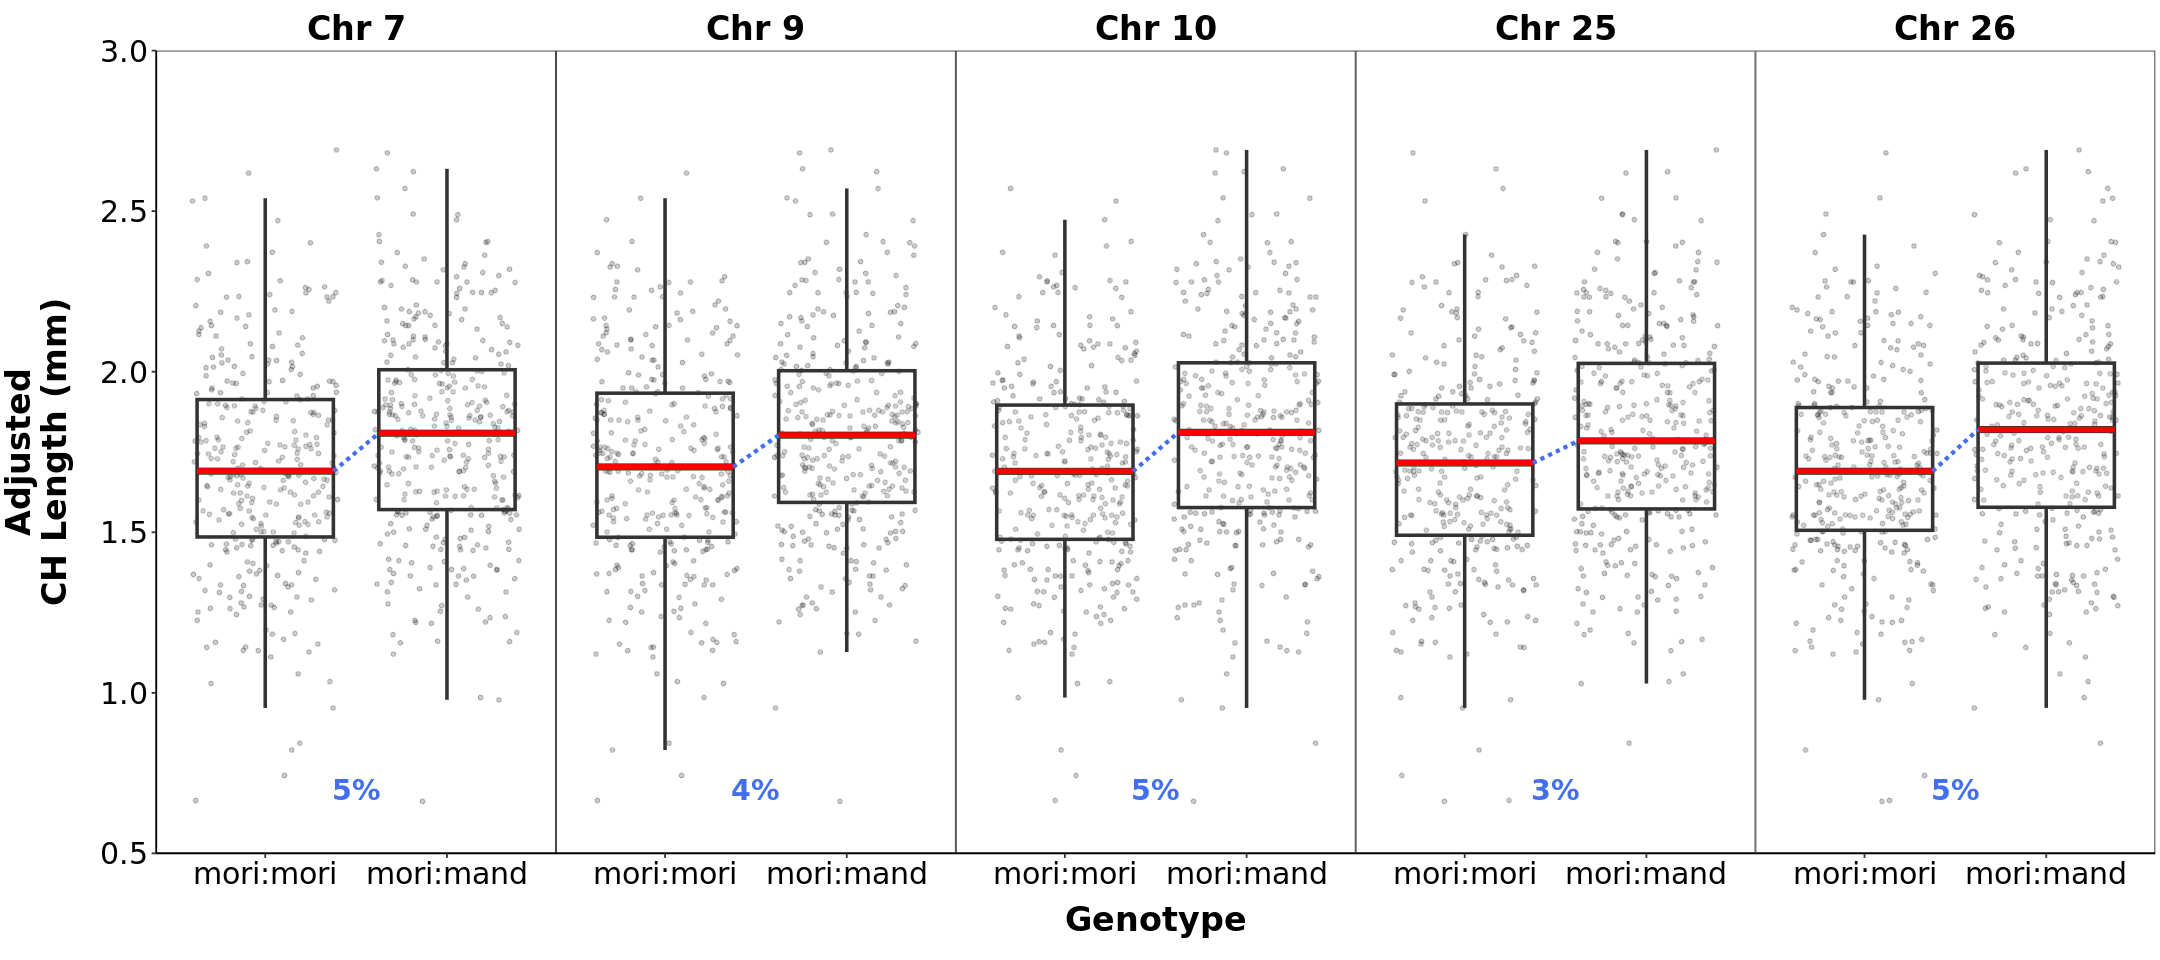

In [17]:
options(repr.plot.width=18, repr.plot.height=8)

supp_fig2b<-ggplot(geno_data_melt_remaining, aes(x = genotype, y = corr_length)) +
  geom_jitter(size = 1, alpha = 0.2) +
  geom_boxplot(size = 1, alpha=0.1, outlier.shape=NA) +
  # Add a stat_summary to draw a red line at the median
  stat_summary(fun = median, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y..),  # Set the ymax and ymin to the median value
               width = 0.75, color = "red", size = 1.5) +  # Adjust the width and color of the line
   scale_y_continuous(limits=c(0.5, 3), breaks=seq(0.5,3, .5), expand=c(0,0))+
geom_text(data=length_avg_remaining, aes(x=1.5, y=0.7, label=paste0(round(Pdiff*100), "%")), color = "royalblue2", size=6, fontface = "bold")+
# Blue line between genotype medians within each chromosome
geom_line(data = medians_edges,
            aes(x = xpos, y = median_length, group = chr),
            colour = "royalblue2", size = 1.2,linetype = "11", inherit.aes = FALSE) +
    theme_bw() +
  theme(
    axis.line = element_line(colour = "black"),
    #aspect.ratio = 1,
    #panel.border = element_blank(),
    text = element_text(size = 12),
    legend.position = "bottom",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    panel.spacing = unit(0, "lines"),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    axis.text.x = element_text(size = 18, colour = "black"),
    strip.text = element_text(size = 20, colour = "black", face="bold"),
    axis.text.y = element_text(size = 18, colour = "black"),
    plot.title = element_text(face = "bold"), plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")
  ) +
  labs(x = "Genotype", y = "Adjusted\nCH Length (mm)")+facet_grid(.~chr)
print(supp_fig2b)
                            

## FigS3D

In [35]:
# Import Genotype at Chr4 QTL Peak Marker along with the corrected CH length
F2_data<-read.csv("../FigS3/Fig2C_F2_data.csv")
F2_data$genotype<-factor(F2_data$genotype, levels=c("mori:mori", "mori:mand", "mand:mand"))
head(F2_data)

,id,length,marker,genotype,chr,corr_length
,<chr>,<dbl>,<chr>,<fct>,<chr>,<dbl>
1,indiv4047,1.394069,Bomo_Chr4:4354915,mori:mand,Chr 4,1.420696
2,indiv4071,1.809799,Bomo_Chr4:4354915,mori:mori,Chr 4,1.829262
3,indiv4117,1.431828,Bomo_Chr4:4354915,mand:mand,Chr 4,1.447710
4,indiv4118,1.730434,Bomo_Chr4:4354915,mori:mand,Chr 4,1.712285
5,indiv4119,1.964063,Bomo_Chr4:4354915,mori:mand,Chr 4,1.960243
6,indiv4120,1.959326,Bomo_Chr4:4354915,mori:mand,Chr 4,1.985953


In [37]:
# Get Median

aggregate(corr_length~genotype, data=F2_data, median) 
F2_chr4_sum<-aggregate(corr_length~genotype, data=F2_data, median) 


genotype,corr_length
<fct>,<dbl>
mori:mori,1.691374
mori:mand,1.953859
mand:mand,2.059462


In [39]:
length_avg_F2<-aggregate(corr_length~marker+genotype+chr, data=F2_data, median)
length_avg_F2<-dcast(length_avg_F2, marker + chr ~ genotype, value.var = "corr_length")
length_avg_F2$Pdiff_mori_mand<-(length_avg_F2$`mori:mand`-length_avg_F2$`mori:mori`)/(3.51 - 0.94)
length_avg_F2$Pdiff_mand_mand<-(length_avg_F2$`mand:mand`-length_avg_F2$`mori:mand`)/(3.51 - 0.94)
(length_avg_F2$`mand:mand`-length_avg_F2$`mori:mand`)/(3.51 - 0.94) # effect size

#length_avg_F2

standard_error <- function(x) {
  sd(x) / sqrt(length(x))
}
length_avg_F2_se<-aggregate(corr_length~marker+genotype+chr, data=F2_data, standard_error)
length_avg_F2_se

[1] 0.0410908

marker,genotype,chr,corr_length
<chr>,<fct>,<chr>,<dbl>
Bomo_Chr4:4354915,mori:mori,Chr 4,0.03013602
Bomo_Chr4:4354915,mori:mand,Chr 4,0.02421922
Bomo_Chr4:4354915,mand:mand,Chr 4,0.03892026


In [40]:
head(F2_data)

,id,length,marker,genotype,chr,corr_length
,<chr>,<dbl>,<chr>,<fct>,<chr>,<dbl>
1,indiv4047,1.394069,Bomo_Chr4:4354915,mori:mand,Chr 4,1.420696
2,indiv4071,1.809799,Bomo_Chr4:4354915,mori:mori,Chr 4,1.829262
3,indiv4117,1.431828,Bomo_Chr4:4354915,mand:mand,Chr 4,1.447710
4,indiv4118,1.730434,Bomo_Chr4:4354915,mori:mand,Chr 4,1.712285
5,indiv4119,1.964063,Bomo_Chr4:4354915,mori:mand,Chr 4,1.960243
6,indiv4120,1.959326,Bomo_Chr4:4354915,mori:mand,Chr 4,1.985953


In [41]:
library(ggpubr)

In [42]:
box_width <- 0.75

medians_df3 <- F2_data %>%
  group_by(chr, genotype) %>%
  summarise(median_length = median(corr_length, na.rm = TRUE), .groups = "drop")


medians_inner3 <- medians_df3 %>%
  group_by(chr) %>%
  arrange(genotype) %>%
  mutate(
    xcenter = as.numeric(factor(genotype)),
    # inner edge coordinates
    xleft  = xcenter - box_width/2,
    xright = xcenter + box_width/2
  ) %>%
  ungroup()

segments_df <- medians_inner3 %>%
  group_by(chr) %>%
  arrange(genotype) %>%
  mutate(next_median = lead(median_length),
         xstart = xright,
         xend   = lead(xleft)) %>%
  filter(!is.na(next_median)) %>%
  select(chr, xstart, xend, y = median_length, yend = next_median)

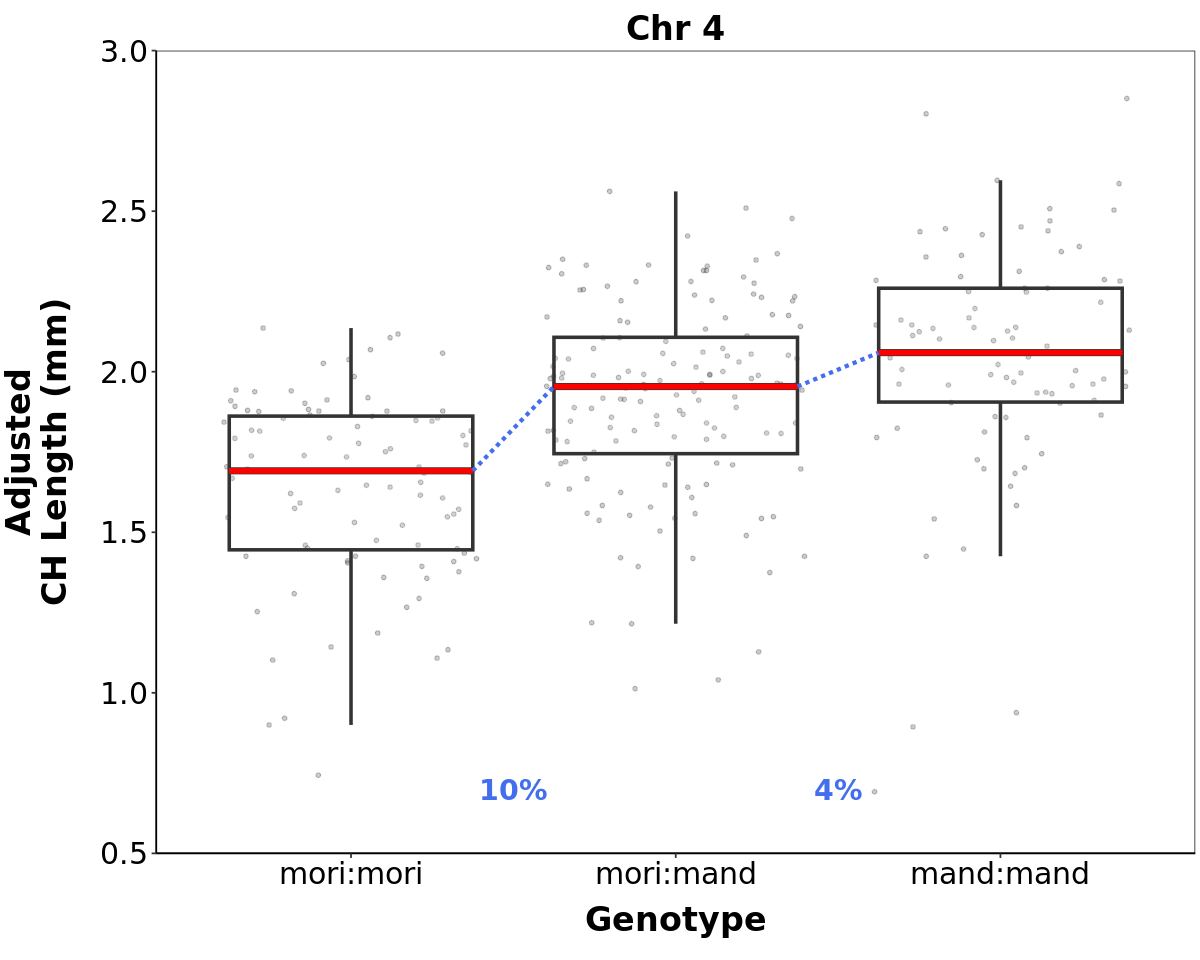

In [61]:
figc<-ggplot(F2_data, aes(x = genotype, y = corr_length)) +
  geom_jitter(size = 1, alpha = 0.2) +
  geom_boxplot(size = 1, alpha=0.1, outlier.shape=NA) +
  # Add a stat_summary to draw a red line at the median
  stat_summary(fun = median, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y..),  # Set the ymax and ymin to the median value
               width = 0.75, color = "red", size = 1.5) +  # Adjust the width and color of the line
   scale_y_continuous(limits=c(0.5, 3), breaks=seq(0.5,3, .5), expand=c(0,0))+
geom_text(data=length_avg_F2, aes(x=1.5, y=0.7, label=paste0(round(Pdiff_mori_mand*100), "%")), color = "royalblue2", size=6, fontface = "bold")+
geom_text(data=length_avg_F2, aes(x=2.5, y=0.7, label=paste0(round(Pdiff_mand_mand*100), "%")), color = "royalblue2", size=6, fontface = "bold")+
geom_segment(
  data = segments_df,
  aes(x = xstart, xend = xend, y = y, yend = yend, group = chr),
  colour = "royalblue2", size = 1.2, linetype = "11", inherit.aes = FALSE)+
theme_bw() +
  theme(
    axis.line = element_line(colour = "black"),
    #aspect.ratio = 1,
    #panel.border = element_blank(),
    text = element_text(size = 12),
    legend.position = "bottom",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    panel.spacing = unit(0, "lines"),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    axis.text.x = element_text(size = 18, colour = "black"),
    strip.text = element_text(size = 20, colour = "black", face="bold"),
    axis.text.y = element_text(size = 18, colour = "black"),
    plot.title = element_text(face = "bold"), plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")
  ) +
  labs(x = "Genotype", y = "Adjusted\nCH Length (mm)")+facet_grid(.~chr)
print(figc)

In [46]:
# Import F2 QTL Plot
load("../FigS3/F2_QTL_plot.RData")

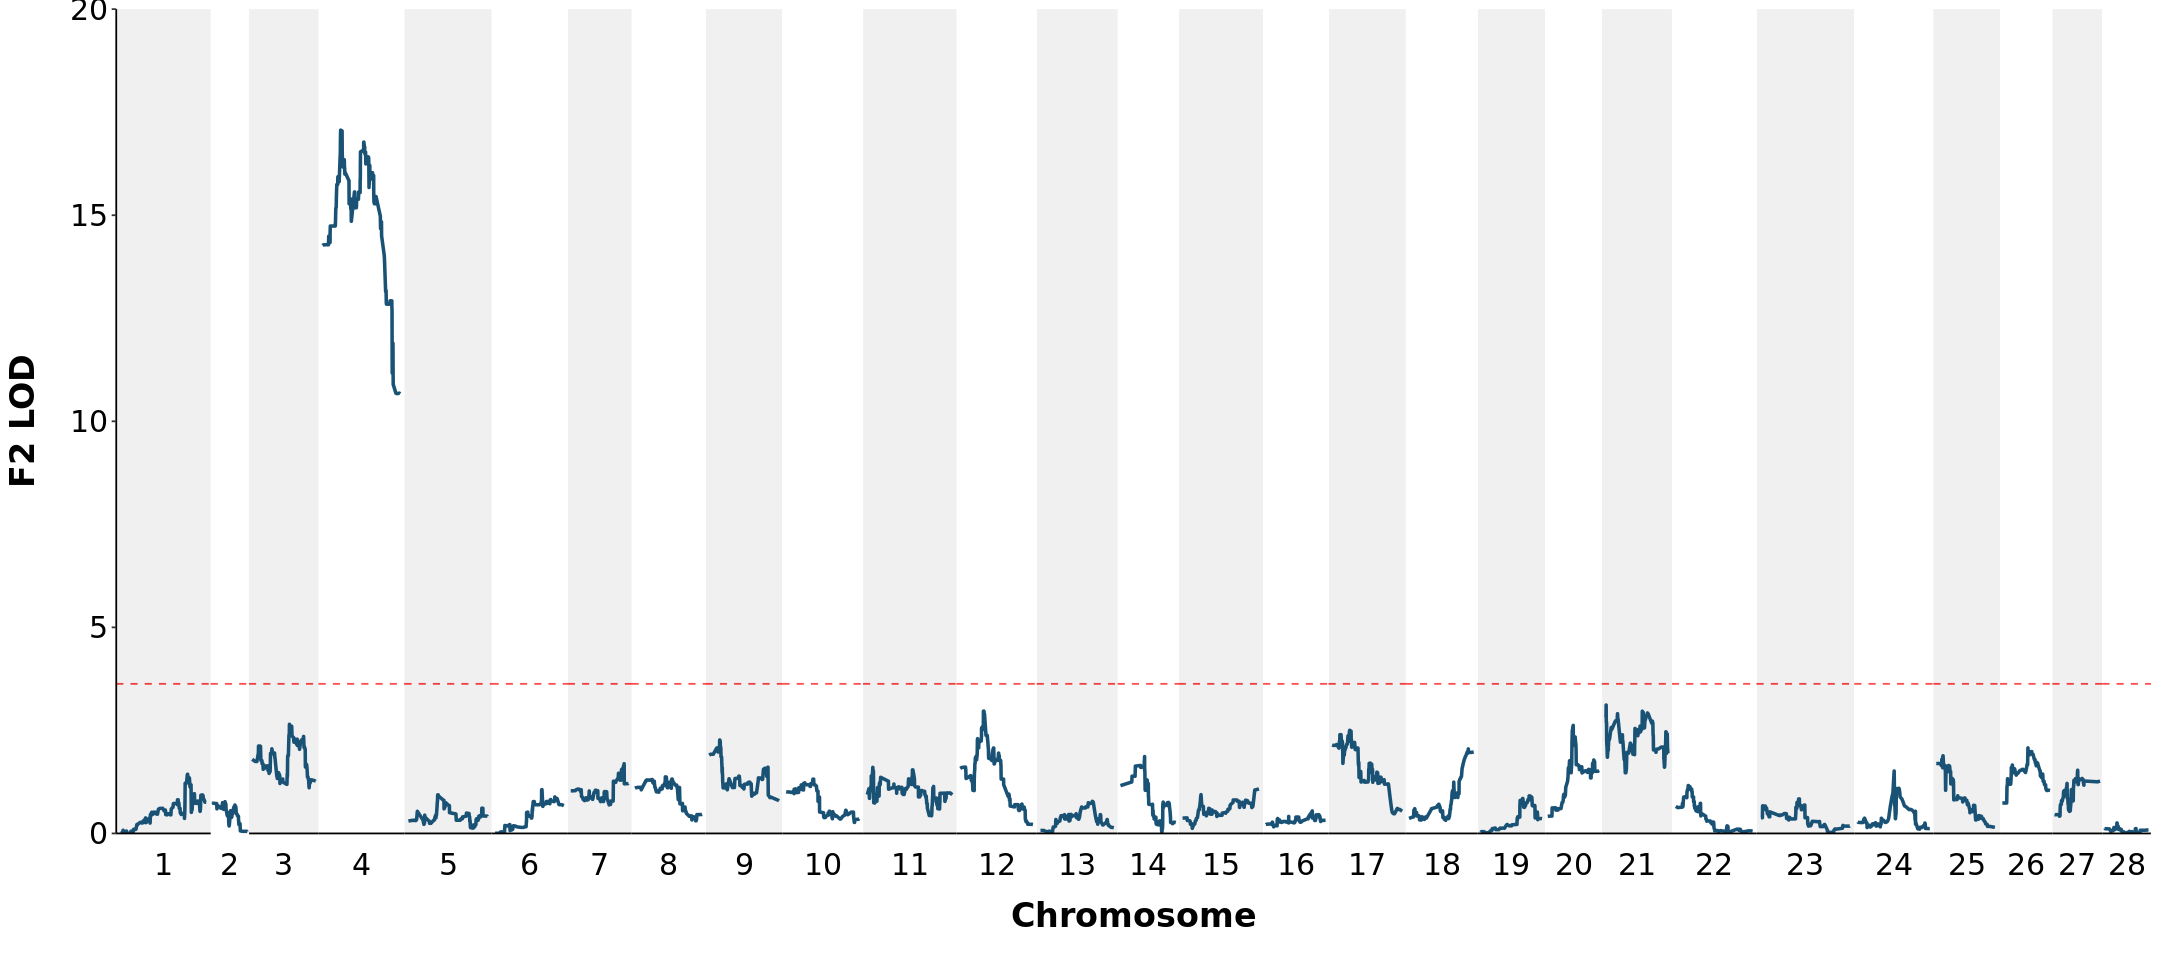

In [49]:
# Plot FigS3B

F2_p<-ggplot(chr_regions, aes(x = pos)) +
  geom_hline(yintercept=3.63, color="red", lty="dashed")+
  geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf, fill = color), alpha = 0.3) +
  xlab("Chromosome")+
  ylab("F2 LOD")+
  geom_line(data = F2_out.hk.df, aes(x = pos, y = lod, group = chr), size=1,  
            color="#1a5276",
           ) +
  facet_grid(. ~ chr, space = "free", scales = "free", switch = "x") +
  scale_x_continuous(breaks = c(1e7, 2e7, 3e7), labels=c(1, 2, 3)) +
  scale_fill_identity() +
    theme_bw()+
scale_y_continuous(limits = c(0, 20), expand = c(0, 0)) +
  theme(panel.spacing = unit(0, "lines"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
       axis.text.x=element_blank(),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    strip.text.x = element_text(size = 18, colour = "black"),
    axis.text.y = element_text(size = 18, colour = "black"),
    plot.title = element_text(face = "bold"),
         axis.ticks.x=element_blank(),
       strip.background = element_blank(),  # Remove strip background
        strip.placement = "outside",
        panel.border = element_blank(),  # Remove panel border
        panel.background = element_rect(fill = "transparent", color = NA),
        plot.background = element_rect(fill = "transparent", color = NA),
        axis.line = element_line())

print(F2_p)

In [63]:
# Import BC QTL markers
lod_for_fit_top3<-read.csv(file = "../FigS3/BC_LOD_top_length.csv")
head(lod_for_fit_top3)

,lod.chr,lod.pos,lod.ci.low,lod.ci.high,lod.lod,chr,pos,lod
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,4,12.68844,12.106047,13.86541,37.648735,4,4272201,37.648735
2,21,21.24121,19.397198,33.37049,8.150137,21,7151921,8.150137
3,5,37.06158,26.684535,44.13904,7.233364,5,12478648,7.233364
4,10,17.65068,6.718654,52.18798,4.653742,10,5942991,4.653742
5,26,19.49508,7.391240,23.88948,3.965129,26,6564000,3.965129
6,7,13.33447,4.181246,25.21830,3.468249,7,4489719,3.468249


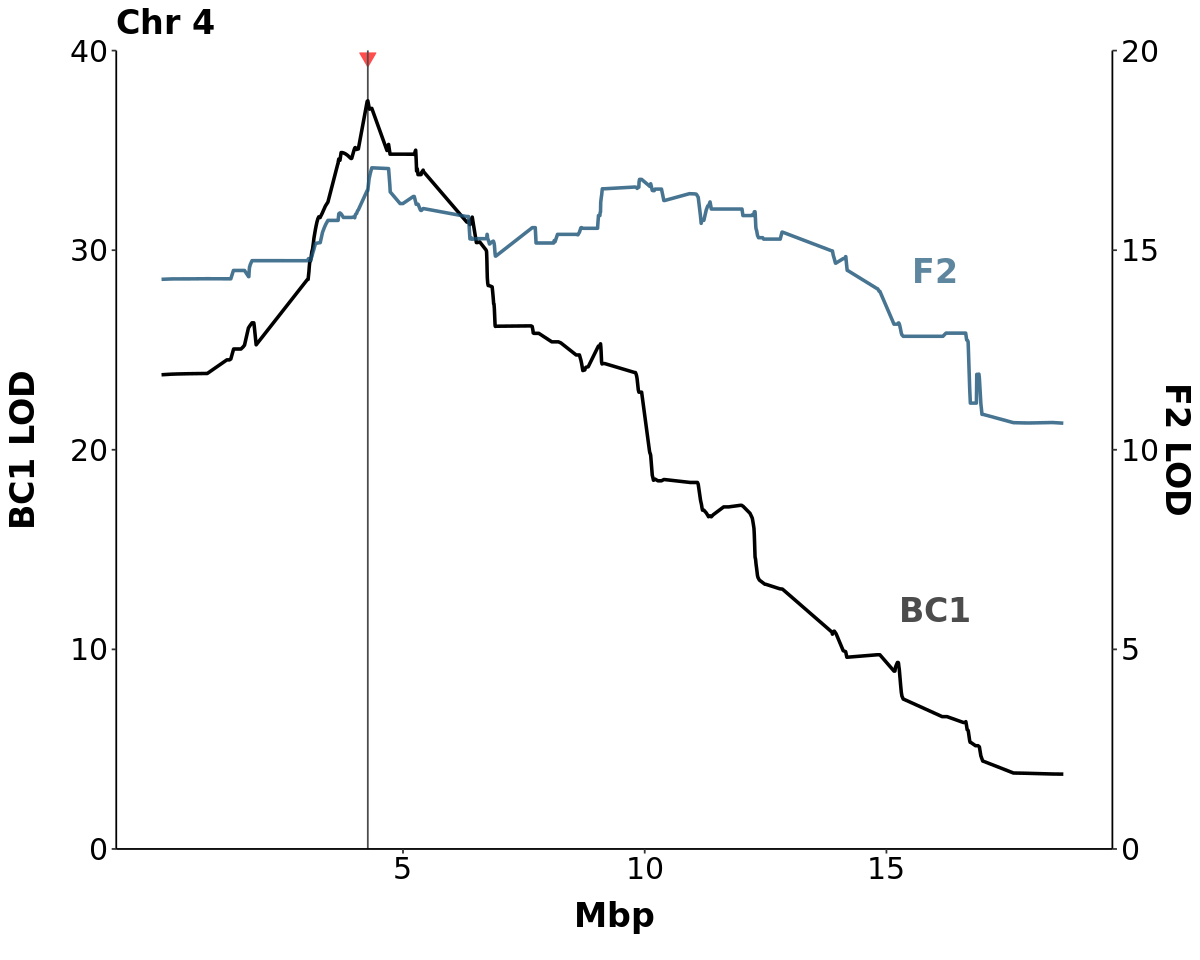

In [55]:
options(repr.plot.width=10, repr.plot.height=8)

#Plot FigS3C

perm_thres=3.02521961503008

pp<-ggplot(chr_regions[which(chr_regions$chr=="4"),], aes(x = pos)) +
#  geom_hline(yintercept=perm_thres, color="red", lty="dashed")+
  geom_point(data=lod_for_fit_top3[which(lod_for_fit_top3$chr==4),], aes(x=pos, y=lod+2),shape = 25, size=3, fill="red", color="red")+
  geom_vline(data=lod_for_fit_top3[which(lod_for_fit_top3$chr==4),], 
             aes(xintercept=pos))+
geom_text(aes(x=16*1e6, y=29, label="F2"), size=7,  color="#1a5276",fontface = "bold")+
geom_text(aes(x=16*1e6, y=12, label="BC1"), size=7,  color="black",fontface = "bold")+
geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf, fill = color), alpha = 0.3) +
  xlab("Mbp")+
  ylab("BC1 LOD")+
  ggtitle("Chr 4")+
  geom_line(data = out.hk.df[which(out.hk.df$chr=="4"),], aes(x = pos, y = lod, group = chr), size=1) +
  geom_line(data = F2_out.hk.df[which(F2_out.hk.df$chr=="4"),], aes(x = pos, y = lod*2, group = chr), color="#1a5276", alpha=0.8, size=1) +
 # geom_hline(yintercept=3.63*2, color="red", lty="dashed")+
  scale_x_continuous(breaks = c(5e6, 1e7, 1.5e7, 2e7), labels=c(5,10,15,20)) +
  scale_fill_identity() +
    theme_bw()+
scale_y_continuous(limits = c(0, 40), expand = c(0, 0),
                  sec.axis = sec_axis(~ .*0.5, name = "F2 LOD")) +
  theme(panel.spacing = unit(0, "lines"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
#       axis.text.x=element_blank(),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, 
    margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    strip.text.x = element_text(size = 20, colour = "black"),
    axis.text = element_text(size = 18, colour = "black"),
    #axis.text.y.right = element_blank(),
    plot.title = element_text(face = "bold", size=20),
         #axis.ticks.x=element_blank(),
       strip.background = element_blank(),  # Remove strip background
        strip.placement = "outside",
        panel.border = element_blank(),  # Remove panel border
        axis.line = element_line())

print(pp)

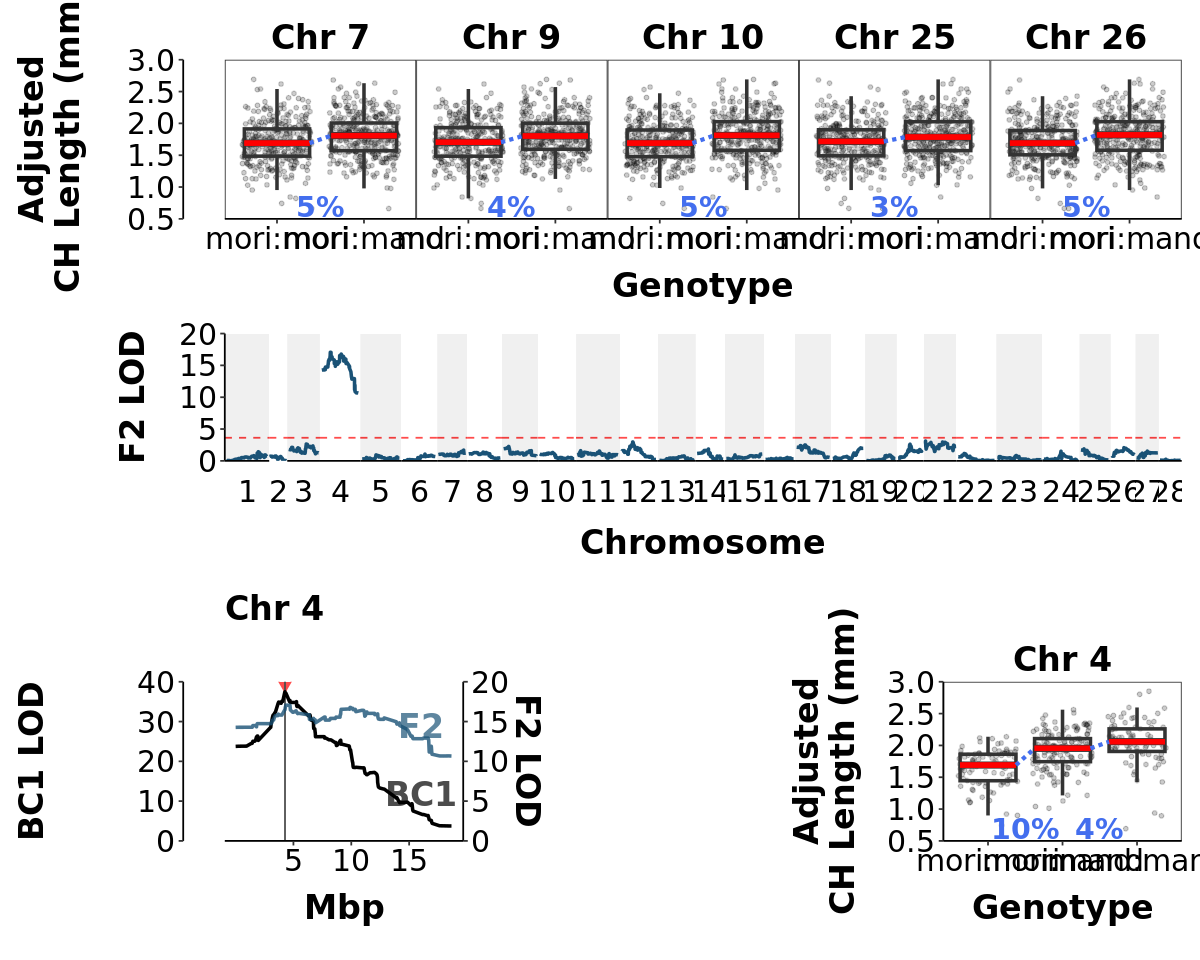

In [62]:
library(patchwork)
layout_design <- "
    DDD
    AAA
    C#B
"
print(F2_p + figc + 
      pp + supp_fig2b +
  plot_layout(design = layout_design, 
              #widths = c(0.72722, 0.2628), # Order matters: affects A, B, C, D
              widths = c(0.5,0.5), # Order matters: affects A, B, C, D
              heights = c(0.5, 0.4,0.5)))